In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import json
import seaborn as sns
import yaml
import os
import io
import ipywidgets as widgets
from os import path
from tqdm import tqdm
from pyvips import Image, Size
from requests import get, post
from joblib import Parallel, delayed
from itertools import product
import matplotlib.pyplot as plt

In [2]:
# Load the config and extract credentials from it
config = yaml.load(open('../config.yml', 'r'), Loader=yaml.SafeLoader)
auth = (config['username'], config['api_key'])
debug_key = config['debug_key']

# Define the default headers that will be send with each request
default_headers = {
    'User-Agent': 'fluffle-notebook (by NoppesTheFolf on Twitter)'
}

# Create the cache directory if it doesn't exist yet
cache_dir = config['cache_dir']
if not path.exists(cache_dir):
    os.makedirs(cache_dir)

# Load previously mapped results
mappings = []
with open('../data/mappings.json') as file:
    mappings = json.load(file)

# Define functions to download files to and get files from cache directory 
def get_location(id: str):
    return path.join(cache_dir, '{}.png'.format(id))

def predownload_image(id: str, download_function):
    dest = get_location(id)
    if path.exists(dest):
        return
    
    response = download_function()
    image = Image.new_from_buffer(response.content, '')
    image.pngsave(dest)
    return dest

In [3]:
# Download the images from e621
def download_e621_post(id):
    def download():
        post_response = get('https://e621.net/posts/{}.json'.format(id), headers=default_headers, auth=auth)
        if post_response.status_code == 404:
            raise Exception('Post with ID {} could not be found.'.format(id))
        
        post_file = post_response.json()['post']['file']
        download_response = get(post_file['url'], headers=default_headers, auth=auth)
        if download_response.status_code == 404:
            raise Exception('File for post with ID {} could not be found.'.format(id))

        return download_response
    
    return predownload_image(id, download)

with open('../data/posts.json', 'r') as file:
    post_groups = json.load(file)

post_ids = pd.Series([item for sublist in post_groups for item in sublist])
if len(post_ids) != len(post_ids.unique()):
    raise Exception('Not all post IDs are unique!')

for post_id in tqdm(np.concatenate(post_groups), desc='Downloading images from e621'):
    download_e621_post(post_id)

In [4]:
# Download the images from unsplash
def download_unsplash(id):
    def download():
        response = get('https://source.unsplash.com/' + id, headers=default_headers)
        if response.status_code == 404:
            raise Exception('No Unsplash image could be found with ID {}.'.format(id))
        
        return response

    return predownload_image(id, download)

with open('../data/unsplash.yml', 'r') as file:
    unsplash = yaml.load(file, Loader=yaml.SafeLoader)

unsplash_ids = np.concatenate(list(map(lambda x: x['ids'] ,unsplash.values())))
for unsplash_id in tqdm(unsplash_ids, desc='Downloading images from Unsplash'):
    download_unsplash(unsplash_id)

In [5]:
def calculate_size(width, height, target):
    def calculate_size(d1, d2, d1_target): return round(d1_target / d1 * d2)

    if width > height:
        return calculate_size(height, width, target), target

    return target, calculate_size(width, height, target)

def fluffle_search(id, target, Q):
    src = get_location(id)

    image = Image.new_from_file(src)
    size = calculate_size(image.width, image.height, target)
    image = image.thumbnail_image(size[0], height=size[1], size=Size.FORCE)
    buffer = image.pngsave_buffer(Q=Q)
    
    headers = default_headers | {
        'Debug-Key': debug_key
    }
    files = {
        'file': buffer
    }
    data = {
        'includeNsfw': True,
        'limit': 128
    }
    response = post("https://api.fluffle.xyz/v1/search", headers=headers, files=files, data=data)
    return response.json()['results']

def search(post_group, post_id, target, Q):
    results = fluffle_search(post_id, target, Q)
    df = pd.json_normalize(results)
    df['target'] = target
    df['quality'] = Q
    df['looked_for_id'] = post_id
    df['e621_id'] = df.apply(lambda row: -1 if row['platform'] != 'e621' else int(row['location'].replace('https://e621.net/posts/', '')), axis=1)
    df['match'] = df['e621_id'].apply(lambda x: 'exact' if x == post_id else 'alternative' if x in post_group else 'nan')

    return df

In [6]:
def search_all(target, Q):
    params = {
        'target': target,
        'Q': Q
    }
    jobs = []
    for post_group in post_groups:
        for post_id in post_group:
            for search_params in product(*params.values()):
                jobs.append([post_group, post_id, *search_params])

    for unsplash_id in unsplash_ids:
        for search_params in product(*params.values()):
            jobs.append([[], unsplash_id, *search_params])

    return Parallel(n_jobs=16)(delayed(search)(*job) for job in tqdm(jobs, desc='Reverse searching using Fluffle'))

dfs = search_all([400, 500, 600, 700], [100])

Reverse searching using Fluffle: 100%|██████████| 652/652 [02:19<00:00,  4.67it/s]


In [7]:
def compute_stats(dfs):
    stats_cols = [
        'stats.average64',
        'stats.avg256', 'stats.best256', 'stats.worst256', 'stats.diff256', 'stats.average256',
        'stats.var1024', 'stats.sum1024', 'stats.std1024', 'stats.median1024', 'stats.avg1024', 'stats.best1024', 'stats.worst1024', 'stats.average1024', 'stats.diff1024',
        'stats.is_best', 'stats.distance_from_best',
        'stats.is_best_1024', 'stats.distance_from_best_1024',
    ]
    cols = ['id', 'looked_for_id', 'thumbnail.location', 'match'] + stats_cols
    
    for df in dfs:
        df['stats.avg256'] = df[['stats.red256',  'stats.green256',  'stats.blue256']].apply(lambda row: np.mean(row), axis=1)
        df['stats.best256'] = df[['stats.red256',  'stats.green256',  'stats.blue256']].apply(lambda row: min(*row), axis=1)
        df['stats.worst256'] = df[['stats.red256',  'stats.green256',  'stats.blue256']].apply(lambda row: max(*row), axis=1)
        df['stats.diff256'] = df['stats.worst256'] - df['stats.best256']

        df['stats.var1024'] = df[['stats.red1024',  'stats.green1024',  'stats.blue1024']].apply(lambda row: np.var(row), axis=1)
        df['stats.sum1024'] = df[['stats.red1024',  'stats.green1024',  'stats.blue1024']].apply(lambda row: np.sum(row), axis=1)
        df['stats.std1024'] = df[['stats.red1024',  'stats.green1024',  'stats.blue1024']].apply(lambda row: np.std(row), axis=1)
        df['stats.median1024'] = df[['stats.red1024',  'stats.green1024',  'stats.blue1024']].apply(lambda row: np.median(row), axis=1)
        df['stats.avg1024'] = df[['stats.red1024',  'stats.green1024',  'stats.blue1024']].apply(lambda row: np.mean(row), axis=1)
        df['stats.best1024'] = df[['stats.red1024',  'stats.green1024',  'stats.blue1024']].apply(lambda row: min(*row), axis=1)
        df['stats.worst1024'] = df[['stats.red1024',  'stats.green1024',  'stats.blue1024']].apply(lambda row: max(*row), axis=1)
        df['stats.diff1024'] = df['stats.worst1024'] - df['stats.best1024']
        
        df.sort_values('stats.avg256', inplace=True)
        df['stats.is_best'] = [True] + (len(df) - 1) * [False]
        df['stats.distance_from_best'] = df['stats.avg256'] - df['stats.avg256'].iloc[0]

        df.sort_values('stats.avg1024', inplace=True)
        df['stats.is_best_1024'] = [True] + (len(df) - 1) * [False]
        df['stats.distance_from_best_1024'] = df['stats.avg1024'] - df['stats.avg1024'].iloc[0]

        df.drop(columns=set(df.columns) - set(cols), inplace=True)

compute_stats(dfs)
df = pd.concat(dfs).reset_index(drop=True)
df.head()

,id,thumbnail.location,stats.average64,stats.average256,stats.average1024,looked_for_id,match,stats.avg256,stats.best256,stats.worst256,...,stats.std1024,stats.median1024,stats.avg1024,stats.best1024,stats.worst1024,stats.diff1024,stats.is_best,stats.distance_from_best,stats.is_best_1024,stats.distance_from_best_1024
0,4343671,https://static.fluffle.xyz/file/fluffle/957ffe...,0,4,6,2055069,nan,2.000000,2,2,...,1.885618,4.0,5.333333,4,8,4,True,0.000000,True,0.000000
1,7799297,https://static.fluffle.xyz/file/fluffle/1557fc...,0,2,14,2055069,nan,2.666667,2,4,...,1.632993,12.0,12.000000,10,14,4,False,0.666667,False,6.666667
2,2603077,https://static.fluffle.xyz/file/fluffle/5e6533...,0,6,20,2055069,exact,5.333333,4,6,...,1.632993,18.0,18.000000,16,20,4,False,3.333333,False,12.666667
3,1333702,https://static.fluffle.xyz/file/fluffle/9ebcbf...,16,110,484,2055069,nan,105.333333,104,108,...,8.379870,468.0,470.666667,462,482,20,False,103.333333,False,465.333333
4,2498960,https://static.fluffle.xyz/file/fluffle/5a5d9f...,16,108,482,2055069,nan,104.666667,102,108,...,8.993825,474.0,474.666667,464,486,22,False,102.666667,False,469.333333


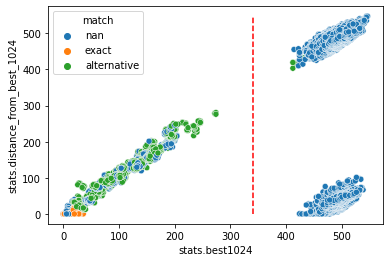

In [8]:
# There is a clear gap in the data
UNLIKELY_THRESHOLD = 340

fig, ax = plt.subplots()
sns.scatterplot(data=df, x='stats.best1024', y='stats.distance_from_best_1024', hue='match', ax=ax)
ax.vlines(UNLIKELY_THRESHOLD, df['stats.distance_from_best_1024'].min(), df['stats.distance_from_best_1024'].max(), linestyles='dashed', colors='red')
plt.show()

<AxesSubplot:xlabel='stats.best1024', ylabel='stats.distance_from_best_1024'>

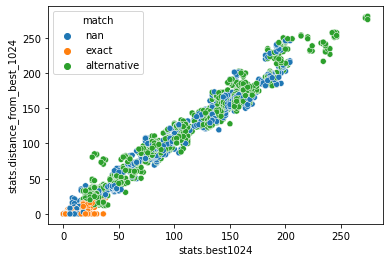

In [9]:
# Take a closer look at all the results on the left side
sns.scatterplot(data=df[df['stats.best1024'] <= UNLIKELY_THRESHOLD], x='stats.best1024', y='stats.distance_from_best_1024', hue='match')

76


<AxesSubplot:xlabel='stats.best1024', ylabel='stats.distance_from_best_1024'>

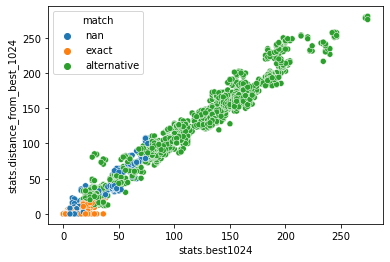

In [10]:
# Everything having a 2x worst match than the worst exact match, we will deem an alternative to save time
ALTERNATIVE_THRESHOLD = df[df['match'] == 'exact']['stats.best1024'].max() * 2
print(ALTERNATIVE_THRESHOLD)

df['match'] = df.apply(lambda row: 'alternative' if row['stats.best1024'] > ALTERNATIVE_THRESHOLD and row['stats.best1024'] <= UNLIKELY_THRESHOLD else row['match'], axis=1)
sns.scatterplot(data=df[df['stats.best1024'] <= UNLIKELY_THRESHOLD], x='stats.best1024', y='stats.distance_from_best_1024', hue='match')

In [11]:
# Apply previously mapped results
df_mappings = pd.DataFrame.from_records(mappings, columns=['id', 'looked_for_id', 'match'])
df = df.merge(df_mappings, on=['id', 'looked_for_id'], how='left')
df['match'] = df.apply(lambda row: row['match_x'] if row['match_x'] != 'nan' else row['match_y'] if str(row['match_y']) != 'nan' else 'unlikely' if row['stats.best1024'] > UNLIKELY_THRESHOLD else 'unknown', axis=1)

df.head()

,id,thumbnail.location,stats.average64,stats.average256,stats.average1024,looked_for_id,match_x,stats.avg256,stats.best256,stats.worst256,...,stats.avg1024,stats.best1024,stats.worst1024,stats.diff1024,stats.is_best,stats.distance_from_best,stats.is_best_1024,stats.distance_from_best_1024,match_y,match
0,4343671,https://static.fluffle.xyz/file/fluffle/957ffe...,0,4,6,2055069,nan,2.000000,2,2,...,5.333333,4,8,4,True,0.000000,True,0.000000,exact,exact
1,7799297,https://static.fluffle.xyz/file/fluffle/1557fc...,0,2,14,2055069,nan,2.666667,2,4,...,12.000000,10,14,4,False,0.666667,False,6.666667,exact,exact
2,2603077,https://static.fluffle.xyz/file/fluffle/5e6533...,0,6,20,2055069,exact,5.333333,4,6,...,18.000000,16,20,4,False,3.333333,False,12.666667,NaN,exact
3,1333702,https://static.fluffle.xyz/file/fluffle/9ebcbf...,16,110,484,2055069,nan,105.333333,104,108,...,470.666667,462,482,20,False,103.333333,False,465.333333,NaN,unlikely
4,2498960,https://static.fluffle.xyz/file/fluffle/5a5d9f...,16,108,482,2055069,nan,104.666667,102,108,...,474.666667,464,486,22,False,102.666667,False,469.333333,NaN,unlikely


<AxesSubplot:xlabel='stats.best1024', ylabel='stats.distance_from_best_1024'>

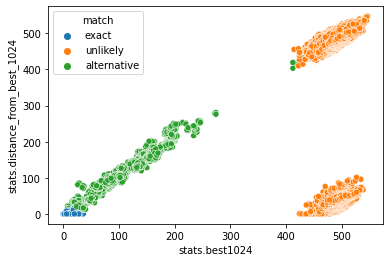

In [12]:
sns.scatterplot(data=df, x='stats.best1024', y='stats.distance_from_best_1024', hue='match')

<AxesSubplot:xlabel='stats.best1024', ylabel='stats.distance_from_best_1024'>

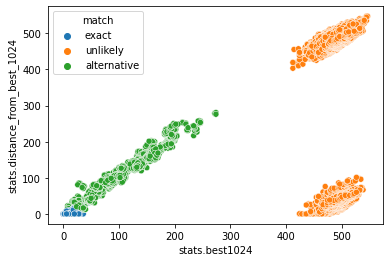

In [13]:
# Anything worse than the unlikely threshold will be deemed an unlikely match. There is no way to know these are alternatives from the data.
df['match'] = df.apply(lambda row: 'unlikely' if row['stats.best1024'] > UNLIKELY_THRESHOLD else row['match'], axis=1)

sns.scatterplot(data=df, x='stats.best1024', y='stats.distance_from_best_1024', hue='match')

In [14]:
# Match results manually, note that this does not work when having reverse searched multiple quality/size combos!
import io
import ipywidgets as widgets

row = None

@widgets.interact(match=[None, 'exact', 'alternative', 'unlikely'])
def show(match):
    global row
    if row is not None and match is None:
        print('Nothing selected.')
        fig, ax = plt.subplots(1, 2, figsize=(15, 15))
        ax[0].imshow(plt.imread(get_location(row['looked_for_id'])))
        ax[1].imshow(plt.imread(io.BytesIO(get(row['thumbnail.location']).content), 'JPEG'))
        plt.show()
        return

    if row is not None and match is not None:
        mappings.append([int(row['id']), int(row['looked_for_id']), match])
        df.at[row.name, 'match'] = match

        with open('../data/mappings.json', 'w') as file:
            json.dump(mappings, file)

    df_unknown = df[df['match'] == 'unknown']
    print(len(df_unknown))
    if len(df_unknown) > 0:
        row = df_unknown.iloc[0]
        fig, ax = plt.subplots(1, 2, figsize=(15, 15))
        ax[0].imshow(plt.imread(get_location(row['looked_for_id'])))
        ax[1].imshow(plt.imread(io.BytesIO(get(row['thumbnail.location']).content), 'JPEG'))
        plt.show()

interactive(children=(Dropdown(description='match', options=(None, 'exact', 'alternative', 'unlikely'), value=…

In [15]:
# We should not be allowed to train/create models if we have not mapped all results
if (df['match'] == 'unknown').any():
    raise Exception('Woah there! You still have not mapped all of the images!')

In [16]:
# We're just going to create a bunch of random forest classifiers and see if anything works out nicely
from itertools import combinations, chain
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

df_matches = df[df['match'] != 'unlikely']

def create_model(cols):
    X = df_matches[cols].copy()
    y = df_matches['match'].copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=123)

    model = RandomForestClassifier(random_state=123).fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return cols, model, f1_score(y_test, y_pred, average='macro')

stats_cols = [
    'stats.average64',
    'stats.avg256', 'stats.best256', 'stats.worst256', 'stats.diff256', 'stats.average256',
    'stats.var1024', 'stats.sum1024', 'stats.std1024', 'stats.median1024', 'stats.avg1024', 'stats.best1024', 'stats.worst1024', 'stats.average1024', 'stats.diff1024',
    'stats.is_best', 'stats.distance_from_best',
    'stats.is_best_1024', 'stats.distance_from_best_1024',
]
pred_cols = list(set(stats_cols) - set(['stats.is_best_1024', 'stats.distance_from_best_1024', 'stats.is_best', 'stats.distance_from_best', 'stats.avg256', 'stats.best256', 'stats.worst256', 'stats.diff256', 'stats.average256']))
scores = []
num_combos = range(1, len(stats_cols) + 1)
train_col_combos = list(chain(*list(map(lambda i: combinations(pred_cols, i), num_combos))))
scores = Parallel(n_jobs=-1)(delayed(create_model)(list(cols)) for cols in tqdm(train_col_combos, desc='Training models'))

df_model = pd.DataFrame.from_records(scores)
df_model[3] = df_model[0].apply(lambda x: len(x))
df_model = df_model.sort_values([2, 3], ascending=[False, True]).head(10)

for row in df_model.itertuples():
    print('Score: {}, Columns: {}'.format(row[3], ', '.join(row[1])))

Training models: 100%|██████████| 1023/1023 [00:23<00:00, 44.07it/s]


Score: 0.9659969900698593, Columns: stats.median1024, stats.worst1024, stats.average1024
Score: 0.9646335744082146, Columns: stats.avg1024, stats.var1024, stats.median1024, stats.worst1024, stats.average64, stats.average1024
Score: 0.9634563043121824, Columns: stats.diff1024, stats.worst1024, stats.average64
Score: 0.9633430699192127, Columns: stats.avg1024, stats.best1024, stats.diff1024, stats.average64, stats.average1024
Score: 0.9633430699192127, Columns: stats.avg1024, stats.best1024, stats.diff1024, stats.average64, stats.average1024, stats.sum1024
Score: 0.9633430699192127, Columns: stats.avg1024, stats.var1024, stats.best1024, stats.median1024, stats.worst1024, stats.average64, stats.average1024, stats.sum1024
Score: 0.9633042023669185, Columns: stats.avg1024, stats.median1024, stats.worst1024, stats.average64, stats.average1024, stats.std1024
Score: 0.9633042023669185, Columns: stats.avg1024, stats.var1024, stats.best1024, stats.median1024, stats.worst1024, stats.average64, st

['stats.median1024', 'stats.worst1024', 'stats.average1024']


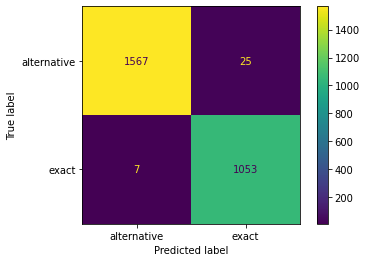

['stats.avg1024', 'stats.var1024', 'stats.median1024', 'stats.worst1024', 'stats.average64', 'stats.average1024']


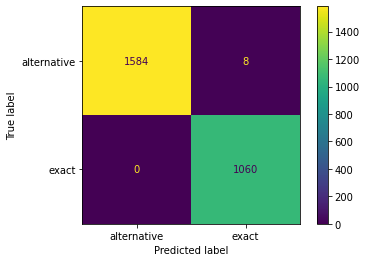

['stats.diff1024', 'stats.worst1024', 'stats.average64']


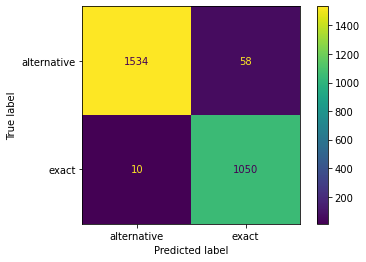

['stats.avg1024', 'stats.best1024', 'stats.diff1024', 'stats.average64', 'stats.average1024']


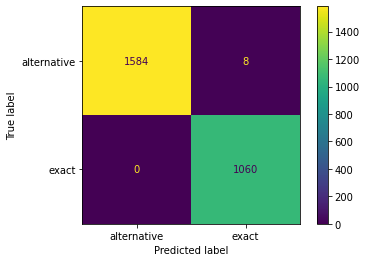

['stats.avg1024', 'stats.best1024', 'stats.diff1024', 'stats.average64', 'stats.average1024', 'stats.sum1024']


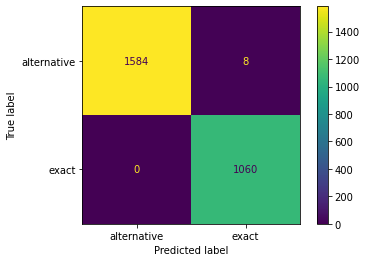

['stats.avg1024', 'stats.var1024', 'stats.best1024', 'stats.median1024', 'stats.worst1024', 'stats.average64', 'stats.average1024', 'stats.sum1024']


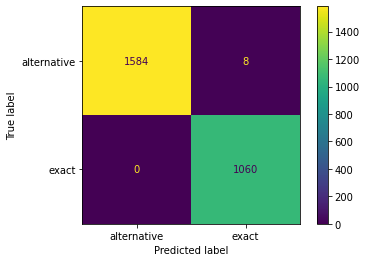

['stats.avg1024', 'stats.median1024', 'stats.worst1024', 'stats.average64', 'stats.average1024', 'stats.std1024']


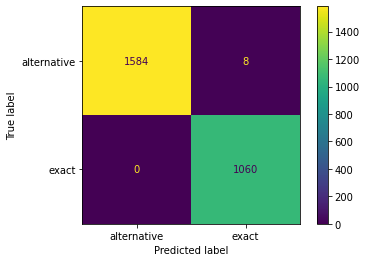

['stats.avg1024', 'stats.var1024', 'stats.best1024', 'stats.median1024', 'stats.worst1024', 'stats.average64', 'stats.average1024']


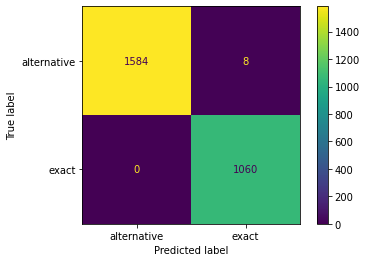

['stats.best1024', 'stats.diff1024', 'stats.average64']


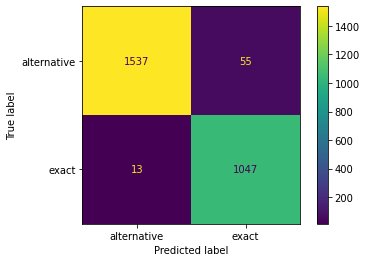

['stats.var1024', 'stats.best1024', 'stats.average64', 'stats.average1024', 'stats.sum1024']


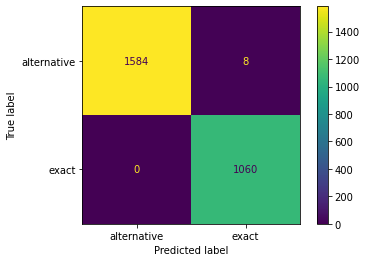

In [17]:
from sklearn.metrics import plot_confusion_matrix

for top_row in df_model.itertuples():
    X = df_matches[list(top_row[1])].copy()
    y = df_matches['match'].copy()

    model = RandomForestClassifier(random_state=123).fit(X, y)

    plot_confusion_matrix(model, X, y)
    print(top_row[1])
    plt.show()

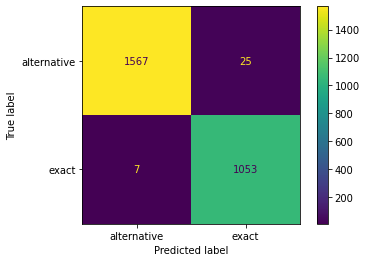

In [23]:
# Display our chosen model
model_cols = ['stats.median1024', 'stats.worst1024', 'stats.average1024']
X = df_matches[model_cols]
y = df_matches['match']

model = RandomForestClassifier().fit(X, y)

plot_confusion_matrix(model, X, y)

In [19]:
# Let's validate if our model performs nicely against high-quality images of a different sizes 
dfs = search_all([474], [100])
compute_stats(dfs)

df_test = pd.concat(dfs).reset_index(drop=True)
df_test = df_test.merge(df[['id', 'looked_for_id', 'match']].drop_duplicates(), on=['id', 'looked_for_id'])
df_test['match'] = df_test['match_y']

Reverse searching using Fluffle: 100%|██████████| 163/163 [00:31<00:00,  5.13it/s]


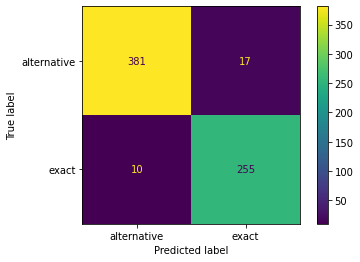

In [24]:
df_temp = df_test.merge(df_matches[['id', 'looked_for_id', 'match']].drop_duplicates(), on=['id', 'looked_for_id']).drop_duplicates()

X = df_temp[model_cols]
y = df_temp['match_y'].values[:,1]
plot_confusion_matrix(model, X, y)

y_pred = model.predict(X)

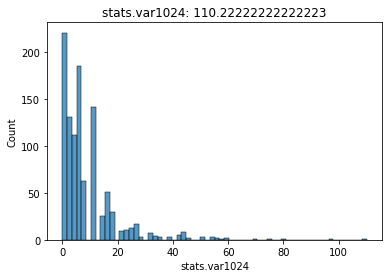

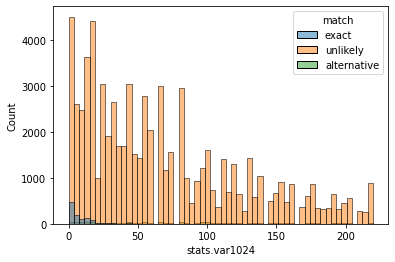

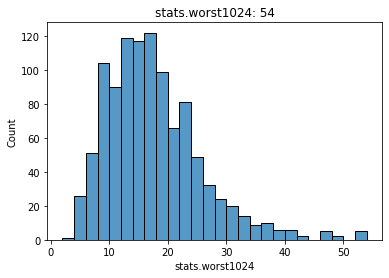

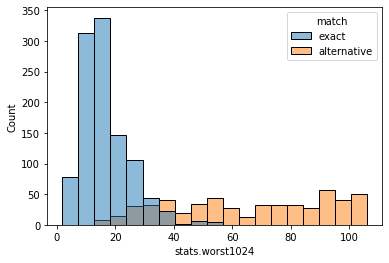

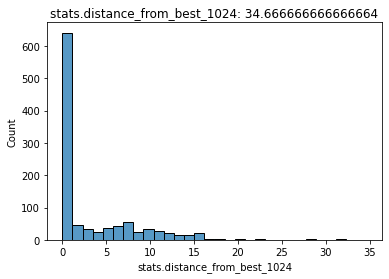

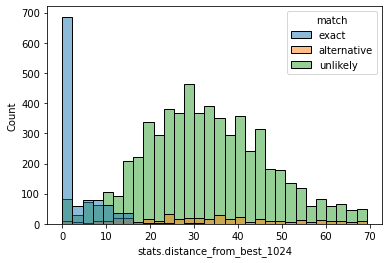

In [27]:
# It doesn't perform acceptably, let's create our own little 'algorithm'
cols = ['stats.var1024', 'stats.worst1024', 'stats.distance_from_best_1024']
for col in cols:
    col_max = df[df['match'] == 'exact'][col].max()

    g = sns.histplot(data=df[df['match'] == 'exact'], x=col)
    g.set(title=f"{col}: {col_max}")
    plt.show()

    sns.histplot(data=df[df[col] < col_max * 2], x=col, hue='match')
    plt.show()

In [28]:
from sklearn.metrics import confusion_matrix

df_not_unlikely = df[df['match'] != 'unlikely']

def predict(row):
    if row['stats.best1024'] > UNLIKELY_THRESHOLD:
        return 'unlikely'
    
    if row['stats.var1024'] > 120:
        return 'alternative'

    if row['stats.worst1024'] > 55:
        return 'alternative'

    if row['stats.distance_from_best_1024'] > 35:
        return 'alternative'

    return 'exact'

df['pred'] = df.apply(predict, axis=1)
confusion_matrix(df['match'], df['pred'])

array([[ 1418,   174,     0],
       [    0,  1060,     0],
       [    0,     0, 80804]], dtype=int64)